# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

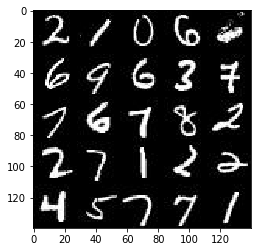

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

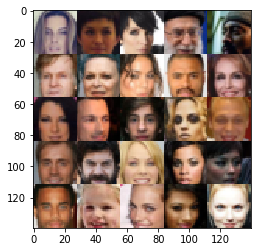

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                'real_inputs')
    z_data = tf.placeholder(tf.float32, (None, z_dim), 'z_data')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_inputs, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.01
    keep_prob = 0.95

    with tf.variable_scope('discriminator', reuse=reuse):
        d1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', activation=None)
        d1 = tf.maximum(alpha * d1, d1)

        d2 = tf.layers.conv2d(d1, 128, 5, strides=2, padding='same', activation=None)
        d2 = tf.layers.batch_normalization(d2, training=True)
        d2 = tf.maximum(alpha * d2, d2)
        d2 = tf.nn.dropout(d2, keep_prob=keep_prob)

        d3 = tf.layers.conv2d(d2, 256, 5, strides=2, padding='same', activation=None)
        d3 = tf.layers.batch_normalization(d3, training=True)
        d3 = tf.maximum(alpha * d3, d3)
        d3 = tf.nn.dropout(d3, keep_prob=keep_prob)

        flat = tf.reshape(d3, (-1,  4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.01
    keep_prob = 0.95
    
    with tf.variable_scope('generator', reuse=not is_train):
        g1 = tf.layers.dense(z, 2 * 2 * 512)
        g1 = tf.reshape(g1, (-1, 2, 2, 512))
        g1 = tf.layers.batch_normalization(g1, training=is_train)
        g1 = tf.maximum(alpha * g1, g1)
        #print (g1.shape)
                
        g2 = tf.layers.conv2d_transpose(g1, 256, 5, strides=2, padding='valid', activation=None)
        g2 = tf.layers.batch_normalization(g2, training=is_train)
        g2 = tf.maximum(alpha * g2, g2)
        g2 = tf.nn.dropout(g2, keep_prob=keep_prob)
        #print (g2.shape)
        
        g3 = tf.layers.conv2d_transpose(g2, 128, 5, strides=2, padding='same', activation=None)
        g3 = tf.layers.batch_normalization(g3, training=is_train)
        g3 = tf.maximum(alpha * g3, g3)   
        g3 = tf.nn.dropout(g3, keep_prob=keep_prob)
        #print (g3.shape)
        
        logits = tf.layers.conv2d_transpose(g3, out_channel_dim, 5, strides=2, padding='same', activation=None)
        
        out = tf.tanh(logits)
        #print (out.shape)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [29]:
import matplotlib.pyplot as plt

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()
    losses = []
    step = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                if step == 1:
                    print('initial output:')
                    show_generator_output(sess, 36, input_z, image_channels, data_image_mode)
                    
                if step % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print(f"Step {step} - Epoch {epoch_i+1}/{epochs} - Gen Loss: {train_loss_g} - Disc Loss: {train_loss_d}")
                    losses.append((train_loss_d, train_loss_g))

                if step % 100 == 0:
                    show_generator_output(sess, 36, input_z, image_channels, data_image_mode)
            print('final epoch output:')            
            show_generator_output(sess, 36, input_z, image_channels, data_image_mode)
        saver.save(sess, './checkpoints/generator.ckpt')
    
    # Plot training losses
    fig, ax = plt.subplots()
    losses = np.array(losses)
    plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
    plt.plot(losses.T[1], label='Generator', alpha=0.5)
    plt.title("Training Losses")
    plt.legend()
    
#    with tf.Session() as sess:
#        sess.run(tf.global_variables_initializer())
#        for epoch_i in range(epoch_count):
#            for batch_images in get_batches(batch_size):
#                # TODO: Train Model
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

initial output:


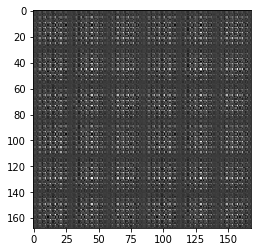

Step 10 - Epoch 1/2 - Gen Loss: 14.396675109863281 - Disc Loss: 0.6524449586868286
Step 20 - Epoch 1/2 - Gen Loss: 0.04625414311885834 - Disc Loss: 3.3919029235839844
Step 30 - Epoch 1/2 - Gen Loss: 19.68694305419922 - Disc Loss: 0.05641203001141548
Step 40 - Epoch 1/2 - Gen Loss: 2.871330499649048 - Disc Loss: 0.06782624125480652
Step 50 - Epoch 1/2 - Gen Loss: 4.326712608337402 - Disc Loss: 0.01922149956226349
Step 60 - Epoch 1/2 - Gen Loss: 5.817218780517578 - Disc Loss: 0.004646305460482836
Step 70 - Epoch 1/2 - Gen Loss: 0.04827097803354263 - Disc Loss: 3.3391125202178955
Step 80 - Epoch 1/2 - Gen Loss: 4.947844982147217 - Disc Loss: 0.7958171963691711
Step 90 - Epoch 1/2 - Gen Loss: 2.2557313442230225 - Disc Loss: 0.2392747700214386
Step 100 - Epoch 1/2 - Gen Loss: 4.086291313171387 - Disc Loss: 0.2536774277687073


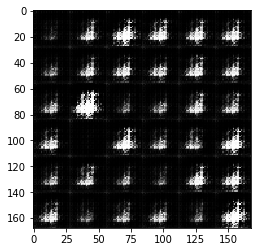

Step 110 - Epoch 1/2 - Gen Loss: 1.8479788303375244 - Disc Loss: 0.33944427967071533
Step 120 - Epoch 1/2 - Gen Loss: 1.9335737228393555 - Disc Loss: 0.20496012270450592
Step 130 - Epoch 1/2 - Gen Loss: 5.353159427642822 - Disc Loss: 0.041457224637269974
Step 140 - Epoch 1/2 - Gen Loss: 7.176229000091553 - Disc Loss: 0.1146644577383995
Step 150 - Epoch 1/2 - Gen Loss: 2.120988368988037 - Disc Loss: 0.22362986207008362
Step 160 - Epoch 1/2 - Gen Loss: 5.48970890045166 - Disc Loss: 0.4206942915916443
Step 170 - Epoch 1/2 - Gen Loss: 2.1145153045654297 - Disc Loss: 0.2624419033527374
Step 180 - Epoch 1/2 - Gen Loss: 0.738828718662262 - Disc Loss: 0.8417735695838928
Step 190 - Epoch 1/2 - Gen Loss: 6.51563835144043 - Disc Loss: 0.8474637269973755
Step 200 - Epoch 1/2 - Gen Loss: 0.7740878462791443 - Disc Loss: 0.8465903997421265


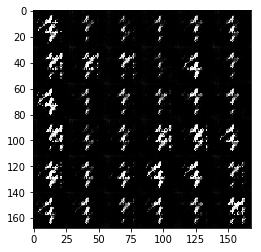

Step 210 - Epoch 1/2 - Gen Loss: 2.84346342086792 - Disc Loss: 0.1534072458744049
Step 220 - Epoch 1/2 - Gen Loss: 1.9377888441085815 - Disc Loss: 0.33941394090652466
Step 230 - Epoch 1/2 - Gen Loss: 3.5933871269226074 - Disc Loss: 0.12997153401374817
Step 240 - Epoch 1/2 - Gen Loss: 2.9484291076660156 - Disc Loss: 0.1402815878391266
Step 250 - Epoch 1/2 - Gen Loss: 2.964773654937744 - Disc Loss: 0.14632689952850342
Step 260 - Epoch 1/2 - Gen Loss: 4.878870010375977 - Disc Loss: 0.37259021401405334
Step 270 - Epoch 1/2 - Gen Loss: 3.8266406059265137 - Disc Loss: 0.11061176657676697
Step 280 - Epoch 1/2 - Gen Loss: 4.109724998474121 - Disc Loss: 0.2863160967826843
Step 290 - Epoch 1/2 - Gen Loss: 1.7206964492797852 - Disc Loss: 0.5680687427520752
Step 300 - Epoch 1/2 - Gen Loss: 2.9193663597106934 - Disc Loss: 0.24290722608566284


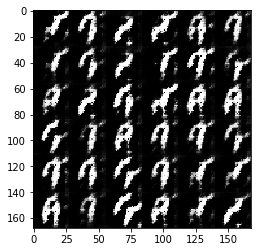

Step 310 - Epoch 1/2 - Gen Loss: 4.590096950531006 - Disc Loss: 0.14761972427368164
Step 320 - Epoch 1/2 - Gen Loss: 3.1643500328063965 - Disc Loss: 0.16530629992485046
Step 330 - Epoch 1/2 - Gen Loss: 3.1181373596191406 - Disc Loss: 0.19079409539699554
Step 340 - Epoch 1/2 - Gen Loss: 6.222576141357422 - Disc Loss: 0.022553689777851105
Step 350 - Epoch 1/2 - Gen Loss: 6.770540237426758 - Disc Loss: 0.10849109292030334
Step 360 - Epoch 1/2 - Gen Loss: 2.436302661895752 - Disc Loss: 0.41939181089401245
Step 370 - Epoch 1/2 - Gen Loss: 1.1333767175674438 - Disc Loss: 0.9512810111045837
Step 380 - Epoch 1/2 - Gen Loss: 5.034905433654785 - Disc Loss: 0.1724867820739746
Step 390 - Epoch 1/2 - Gen Loss: 0.4441174864768982 - Disc Loss: 1.7530920505523682
Step 400 - Epoch 1/2 - Gen Loss: 3.0379791259765625 - Disc Loss: 0.18208688497543335


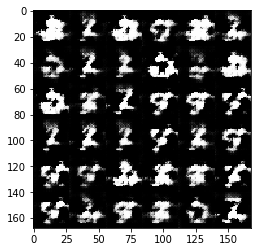

Step 410 - Epoch 1/2 - Gen Loss: 2.117093563079834 - Disc Loss: 0.3560132086277008
Step 420 - Epoch 1/2 - Gen Loss: 3.3218226432800293 - Disc Loss: 0.2973388135433197
Step 430 - Epoch 1/2 - Gen Loss: 2.3009605407714844 - Disc Loss: 0.4615653455257416
Step 440 - Epoch 1/2 - Gen Loss: 2.4049224853515625 - Disc Loss: 0.3228934109210968
Step 450 - Epoch 1/2 - Gen Loss: 1.3385465145111084 - Disc Loss: 0.5078310966491699
Step 460 - Epoch 1/2 - Gen Loss: 1.8122093677520752 - Disc Loss: 0.49204352498054504
Step 470 - Epoch 1/2 - Gen Loss: 0.6949110627174377 - Disc Loss: 1.2349786758422852
Step 480 - Epoch 1/2 - Gen Loss: 2.7195160388946533 - Disc Loss: 0.41048485040664673
Step 490 - Epoch 1/2 - Gen Loss: 5.676788806915283 - Disc Loss: 0.26259690523147583
Step 500 - Epoch 1/2 - Gen Loss: 1.4974796772003174 - Disc Loss: 0.5385573506355286


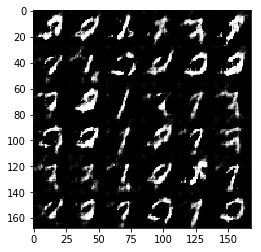

Step 510 - Epoch 1/2 - Gen Loss: 3.7608227729797363 - Disc Loss: 0.4675341546535492
Step 520 - Epoch 1/2 - Gen Loss: 3.5350711345672607 - Disc Loss: 0.3834328055381775
Step 530 - Epoch 1/2 - Gen Loss: 3.8280203342437744 - Disc Loss: 0.5147585272789001
Step 540 - Epoch 1/2 - Gen Loss: 2.458052635192871 - Disc Loss: 0.30180245637893677
Step 550 - Epoch 1/2 - Gen Loss: 8.035737991333008 - Disc Loss: 1.2580606937408447
Step 560 - Epoch 1/2 - Gen Loss: 3.5455880165100098 - Disc Loss: 0.5757399797439575
Step 570 - Epoch 1/2 - Gen Loss: 1.7562284469604492 - Disc Loss: 0.4531056880950928
Step 580 - Epoch 1/2 - Gen Loss: 1.0962679386138916 - Disc Loss: 0.7319143414497375
Step 590 - Epoch 1/2 - Gen Loss: 1.5360099077224731 - Disc Loss: 0.5591676235198975
Step 600 - Epoch 1/2 - Gen Loss: 1.4280004501342773 - Disc Loss: 0.5353661179542542


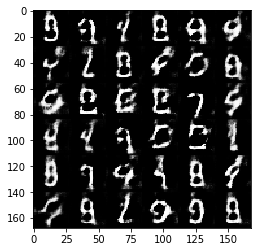

Step 610 - Epoch 1/2 - Gen Loss: 1.8874821662902832 - Disc Loss: 0.45717576146125793
Step 620 - Epoch 1/2 - Gen Loss: 1.2666406631469727 - Disc Loss: 0.7709923982620239
Step 630 - Epoch 1/2 - Gen Loss: 1.8773770332336426 - Disc Loss: 0.5262458324432373
Step 640 - Epoch 1/2 - Gen Loss: 3.233137607574463 - Disc Loss: 0.5333015322685242
Step 650 - Epoch 1/2 - Gen Loss: 1.5719553232192993 - Disc Loss: 0.6060592532157898
Step 660 - Epoch 1/2 - Gen Loss: 2.1457369327545166 - Disc Loss: 0.5017759799957275
Step 670 - Epoch 1/2 - Gen Loss: 1.4774115085601807 - Disc Loss: 0.6429434418678284
Step 680 - Epoch 1/2 - Gen Loss: 1.0762112140655518 - Disc Loss: 0.8512570261955261
Step 690 - Epoch 1/2 - Gen Loss: 1.829648733139038 - Disc Loss: 0.5828385353088379
Step 700 - Epoch 1/2 - Gen Loss: 2.1474151611328125 - Disc Loss: 0.40375077724456787


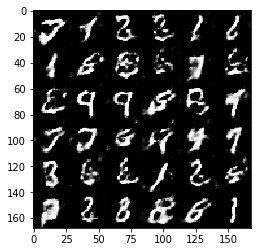

Step 710 - Epoch 1/2 - Gen Loss: 1.0548717975616455 - Disc Loss: 0.7445419430732727
Step 720 - Epoch 1/2 - Gen Loss: 1.0779740810394287 - Disc Loss: 0.8506292104721069
Step 730 - Epoch 1/2 - Gen Loss: 3.2379698753356934 - Disc Loss: 0.7342883348464966
Step 740 - Epoch 1/2 - Gen Loss: 0.8942030668258667 - Disc Loss: 0.9170010089874268
Step 750 - Epoch 1/2 - Gen Loss: 2.1886088848114014 - Disc Loss: 0.4422609508037567
Step 760 - Epoch 1/2 - Gen Loss: 2.4778313636779785 - Disc Loss: 0.4695585370063782
Step 770 - Epoch 1/2 - Gen Loss: 3.237797260284424 - Disc Loss: 0.783280074596405
Step 780 - Epoch 1/2 - Gen Loss: 2.3189830780029297 - Disc Loss: 0.37137115001678467
Step 790 - Epoch 1/2 - Gen Loss: 1.4438536167144775 - Disc Loss: 0.5788634419441223
Step 800 - Epoch 1/2 - Gen Loss: 1.3955633640289307 - Disc Loss: 0.5735906362533569


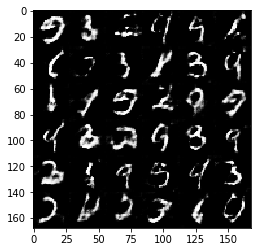

Step 810 - Epoch 1/2 - Gen Loss: 1.3173613548278809 - Disc Loss: 0.610863208770752
Step 820 - Epoch 1/2 - Gen Loss: 1.371252417564392 - Disc Loss: 0.5728195905685425
Step 830 - Epoch 1/2 - Gen Loss: 1.5098563432693481 - Disc Loss: 0.526980996131897
Step 840 - Epoch 1/2 - Gen Loss: 1.8963819742202759 - Disc Loss: 0.6836515665054321
Step 850 - Epoch 1/2 - Gen Loss: 1.4681057929992676 - Disc Loss: 0.6238660216331482
Step 860 - Epoch 1/2 - Gen Loss: 0.7189896106719971 - Disc Loss: 1.1243422031402588
Step 870 - Epoch 1/2 - Gen Loss: 0.3486425280570984 - Disc Loss: 1.5879981517791748
Step 880 - Epoch 1/2 - Gen Loss: 3.045344829559326 - Disc Loss: 0.8127118349075317
Step 890 - Epoch 1/2 - Gen Loss: 1.6634209156036377 - Disc Loss: 0.7218999862670898
Step 900 - Epoch 1/2 - Gen Loss: 2.96875 - Disc Loss: 0.9087833166122437


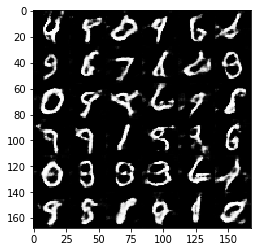

Step 910 - Epoch 1/2 - Gen Loss: 2.348559856414795 - Disc Loss: 0.7547297477722168
Step 920 - Epoch 1/2 - Gen Loss: 1.622670292854309 - Disc Loss: 0.5847755670547485
Step 930 - Epoch 1/2 - Gen Loss: 1.1208256483078003 - Disc Loss: 0.7698631286621094
final epoch output:


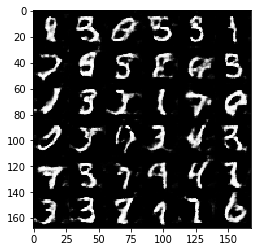

Step 940 - Epoch 2/2 - Gen Loss: 1.8409144878387451 - Disc Loss: 0.8692388534545898
Step 950 - Epoch 2/2 - Gen Loss: 2.9092612266540527 - Disc Loss: 1.1497833728790283
Step 960 - Epoch 2/2 - Gen Loss: 1.1714860200881958 - Disc Loss: 0.9335958957672119
Step 970 - Epoch 2/2 - Gen Loss: 0.698381245136261 - Disc Loss: 1.0813480615615845
Step 980 - Epoch 2/2 - Gen Loss: 0.8574963808059692 - Disc Loss: 0.8319019079208374
Step 990 - Epoch 2/2 - Gen Loss: 1.9603395462036133 - Disc Loss: 0.6605510115623474
Step 1000 - Epoch 2/2 - Gen Loss: 1.6121472120285034 - Disc Loss: 0.8191445469856262


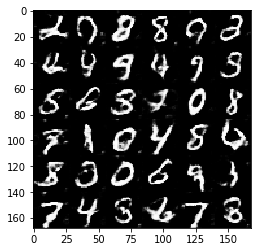

Step 1010 - Epoch 2/2 - Gen Loss: 0.7768275737762451 - Disc Loss: 1.062110185623169
Step 1020 - Epoch 2/2 - Gen Loss: 2.131351947784424 - Disc Loss: 0.781753420829773
Step 1030 - Epoch 2/2 - Gen Loss: 2.000941514968872 - Disc Loss: 0.7916996479034424
Step 1040 - Epoch 2/2 - Gen Loss: 1.7764484882354736 - Disc Loss: 0.6962329745292664
Step 1050 - Epoch 2/2 - Gen Loss: 0.8274576663970947 - Disc Loss: 1.0351810455322266
Step 1060 - Epoch 2/2 - Gen Loss: 1.5312695503234863 - Disc Loss: 0.9602319002151489
Step 1070 - Epoch 2/2 - Gen Loss: 1.192138910293579 - Disc Loss: 0.8286099433898926
Step 1080 - Epoch 2/2 - Gen Loss: 0.6523339152336121 - Disc Loss: 1.052101492881775
Step 1090 - Epoch 2/2 - Gen Loss: 0.6633732318878174 - Disc Loss: 1.135651707649231
Step 1100 - Epoch 2/2 - Gen Loss: 0.881332278251648 - Disc Loss: 0.9133334755897522


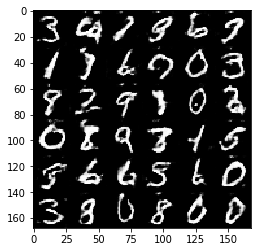

Step 1110 - Epoch 2/2 - Gen Loss: 2.2661781311035156 - Disc Loss: 0.7767738103866577
Step 1120 - Epoch 2/2 - Gen Loss: 1.023388385772705 - Disc Loss: 0.8738912343978882
Step 1130 - Epoch 2/2 - Gen Loss: 1.5166772603988647 - Disc Loss: 0.6943323612213135
Step 1140 - Epoch 2/2 - Gen Loss: 1.0535024404525757 - Disc Loss: 0.9671270251274109
Step 1150 - Epoch 2/2 - Gen Loss: 0.8167371153831482 - Disc Loss: 0.9403026103973389
Step 1160 - Epoch 2/2 - Gen Loss: 1.4830702543258667 - Disc Loss: 0.6587969064712524
Step 1170 - Epoch 2/2 - Gen Loss: 0.5697776079177856 - Disc Loss: 1.2089771032333374
Step 1180 - Epoch 2/2 - Gen Loss: 0.6841215491294861 - Disc Loss: 1.1586517095565796
Step 1190 - Epoch 2/2 - Gen Loss: 0.665981650352478 - Disc Loss: 1.0164724588394165
Step 1200 - Epoch 2/2 - Gen Loss: 0.7645666599273682 - Disc Loss: 1.1073582172393799


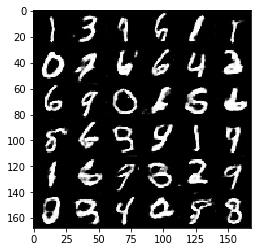

Step 1210 - Epoch 2/2 - Gen Loss: 0.4254245460033417 - Disc Loss: 1.4917359352111816
Step 1220 - Epoch 2/2 - Gen Loss: 0.7342690229415894 - Disc Loss: 1.05752694606781
Step 1230 - Epoch 2/2 - Gen Loss: 1.7155897617340088 - Disc Loss: 0.7596331834793091
Step 1240 - Epoch 2/2 - Gen Loss: 1.0164966583251953 - Disc Loss: 0.9017590284347534
Step 1250 - Epoch 2/2 - Gen Loss: 0.6551868319511414 - Disc Loss: 1.2438371181488037
Step 1260 - Epoch 2/2 - Gen Loss: 1.670623540878296 - Disc Loss: 0.8754491209983826
Step 1270 - Epoch 2/2 - Gen Loss: 0.7744999527931213 - Disc Loss: 1.0276137590408325
Step 1280 - Epoch 2/2 - Gen Loss: 2.6528077125549316 - Disc Loss: 1.2317899465560913
Step 1290 - Epoch 2/2 - Gen Loss: 0.9085153341293335 - Disc Loss: 0.9501610398292542
Step 1300 - Epoch 2/2 - Gen Loss: 1.3751881122589111 - Disc Loss: 0.7860901355743408


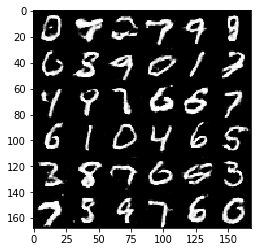

Step 1310 - Epoch 2/2 - Gen Loss: 1.633981466293335 - Disc Loss: 0.6397249698638916
Step 1320 - Epoch 2/2 - Gen Loss: 3.5931525230407715 - Disc Loss: 1.5667550563812256
Step 1330 - Epoch 2/2 - Gen Loss: 0.9070268273353577 - Disc Loss: 0.8486817479133606
Step 1340 - Epoch 2/2 - Gen Loss: 0.9310612678527832 - Disc Loss: 0.9309820532798767
Step 1350 - Epoch 2/2 - Gen Loss: 1.0943365097045898 - Disc Loss: 0.7789179682731628
Step 1360 - Epoch 2/2 - Gen Loss: 1.198103904724121 - Disc Loss: 0.7518391609191895
Step 1370 - Epoch 2/2 - Gen Loss: 0.591888964176178 - Disc Loss: 1.3723719120025635
Step 1380 - Epoch 2/2 - Gen Loss: 1.3736817836761475 - Disc Loss: 1.0066251754760742
Step 1390 - Epoch 2/2 - Gen Loss: 1.4271519184112549 - Disc Loss: 0.9093983173370361
Step 1400 - Epoch 2/2 - Gen Loss: 0.8894000053405762 - Disc Loss: 0.8789684772491455


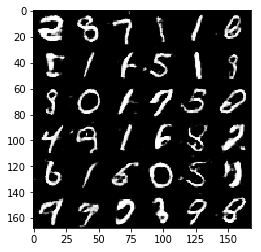

Step 1410 - Epoch 2/2 - Gen Loss: 0.5975813865661621 - Disc Loss: 1.214231252670288
Step 1420 - Epoch 2/2 - Gen Loss: 0.6697380542755127 - Disc Loss: 1.1146093606948853
Step 1430 - Epoch 2/2 - Gen Loss: 1.3433917760849 - Disc Loss: 0.7784069776535034
Step 1440 - Epoch 2/2 - Gen Loss: 1.4288053512573242 - Disc Loss: 0.8237853050231934
Step 1450 - Epoch 2/2 - Gen Loss: 1.1038572788238525 - Disc Loss: 0.7680133581161499
Step 1460 - Epoch 2/2 - Gen Loss: 0.7895117998123169 - Disc Loss: 1.0071046352386475
Step 1470 - Epoch 2/2 - Gen Loss: 1.587647795677185 - Disc Loss: 0.813146710395813
Step 1480 - Epoch 2/2 - Gen Loss: 1.5431361198425293 - Disc Loss: 0.7726449966430664
Step 1490 - Epoch 2/2 - Gen Loss: 2.7490806579589844 - Disc Loss: 0.9909653663635254
Step 1500 - Epoch 2/2 - Gen Loss: 2.228334665298462 - Disc Loss: 0.5760654807090759


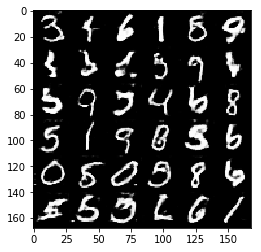

Step 1510 - Epoch 2/2 - Gen Loss: 1.4931631088256836 - Disc Loss: 0.631173849105835
Step 1520 - Epoch 2/2 - Gen Loss: 2.004417657852173 - Disc Loss: 0.8225539922714233
Step 1530 - Epoch 2/2 - Gen Loss: 0.8218677639961243 - Disc Loss: 0.9221037030220032
Step 1540 - Epoch 2/2 - Gen Loss: 1.0088952779769897 - Disc Loss: 0.8406524062156677
Step 1550 - Epoch 2/2 - Gen Loss: 1.1671338081359863 - Disc Loss: 0.9239708781242371
Step 1560 - Epoch 2/2 - Gen Loss: 0.7581789493560791 - Disc Loss: 1.0406287908554077
Step 1570 - Epoch 2/2 - Gen Loss: 0.8498328924179077 - Disc Loss: 0.8545573353767395
Step 1580 - Epoch 2/2 - Gen Loss: 0.5516514778137207 - Disc Loss: 1.1964412927627563
Step 1590 - Epoch 2/2 - Gen Loss: 0.6090308427810669 - Disc Loss: 1.1396411657333374
Step 1600 - Epoch 2/2 - Gen Loss: 0.701714277267456 - Disc Loss: 1.083099365234375


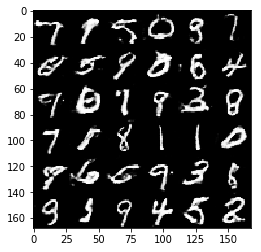

Step 1610 - Epoch 2/2 - Gen Loss: 0.4596707224845886 - Disc Loss: 1.3021514415740967
Step 1620 - Epoch 2/2 - Gen Loss: 1.6949799060821533 - Disc Loss: 0.664253830909729
Step 1630 - Epoch 2/2 - Gen Loss: 2.4750659465789795 - Disc Loss: 1.1973905563354492
Step 1640 - Epoch 2/2 - Gen Loss: 1.278251051902771 - Disc Loss: 0.6191519498825073
Step 1650 - Epoch 2/2 - Gen Loss: 2.0117180347442627 - Disc Loss: 1.1200777292251587
Step 1660 - Epoch 2/2 - Gen Loss: 0.5682322978973389 - Disc Loss: 1.29511296749115
Step 1670 - Epoch 2/2 - Gen Loss: 0.4122660756111145 - Disc Loss: 1.6226786375045776
Step 1680 - Epoch 2/2 - Gen Loss: 1.2880041599273682 - Disc Loss: 0.8369635343551636
Step 1690 - Epoch 2/2 - Gen Loss: 0.7198401689529419 - Disc Loss: 0.9545787572860718
Step 1700 - Epoch 2/2 - Gen Loss: 0.990871787071228 - Disc Loss: 0.8704971075057983


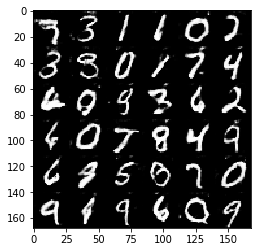

Step 1710 - Epoch 2/2 - Gen Loss: 1.8497880697250366 - Disc Loss: 0.8037731051445007
Step 1720 - Epoch 2/2 - Gen Loss: 1.3092429637908936 - Disc Loss: 0.629814088344574
Step 1730 - Epoch 2/2 - Gen Loss: 1.2812751531600952 - Disc Loss: 0.689656138420105
Step 1740 - Epoch 2/2 - Gen Loss: 0.8924176692962646 - Disc Loss: 0.7596352100372314
Step 1750 - Epoch 2/2 - Gen Loss: 0.4207307994365692 - Disc Loss: 1.5692799091339111
Step 1760 - Epoch 2/2 - Gen Loss: 2.461278200149536 - Disc Loss: 0.7475110292434692
Step 1770 - Epoch 2/2 - Gen Loss: 1.4025355577468872 - Disc Loss: 1.0151338577270508
Step 1780 - Epoch 2/2 - Gen Loss: 2.187448501586914 - Disc Loss: 1.0974451303482056
Step 1790 - Epoch 2/2 - Gen Loss: 0.9941470623016357 - Disc Loss: 0.8209401369094849
Step 1800 - Epoch 2/2 - Gen Loss: 1.0375196933746338 - Disc Loss: 0.7210962176322937


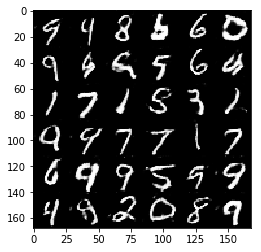

Step 1810 - Epoch 2/2 - Gen Loss: 0.8063584566116333 - Disc Loss: 0.862568736076355
Step 1820 - Epoch 2/2 - Gen Loss: 1.5051276683807373 - Disc Loss: 0.6679574251174927
Step 1830 - Epoch 2/2 - Gen Loss: 0.760248064994812 - Disc Loss: 0.9165834784507751
Step 1840 - Epoch 2/2 - Gen Loss: 1.3246705532073975 - Disc Loss: 0.6327444911003113
Step 1850 - Epoch 2/2 - Gen Loss: 2.7801904678344727 - Disc Loss: 0.7521361708641052
Step 1860 - Epoch 2/2 - Gen Loss: 1.020938754081726 - Disc Loss: 0.9126104712486267
Step 1870 - Epoch 2/2 - Gen Loss: 1.60060715675354 - Disc Loss: 0.9066622257232666
final epoch output:


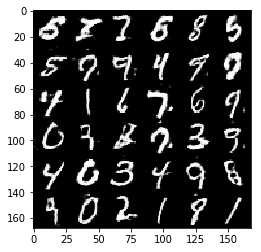

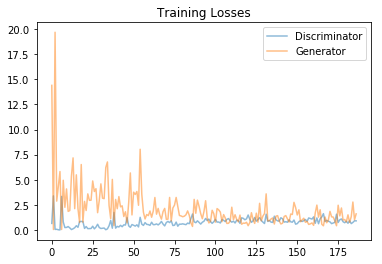

In [32]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

initial output:


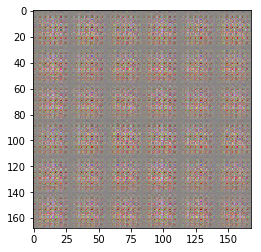

Step 10 - Epoch 1/1 - Gen Loss: 11.933086395263672 - Disc Loss: 0.3544631898403168
Step 20 - Epoch 1/1 - Gen Loss: 5.394014358520508 - Disc Loss: 0.05225652456283569
Step 30 - Epoch 1/1 - Gen Loss: 14.0792818069458 - Disc Loss: 0.9299138188362122
Step 40 - Epoch 1/1 - Gen Loss: 0.09549583494663239 - Disc Loss: 3.2583303451538086
Step 50 - Epoch 1/1 - Gen Loss: 1.2123663425445557 - Disc Loss: 0.7505217790603638
Step 60 - Epoch 1/1 - Gen Loss: 0.3318135440349579 - Disc Loss: 2.0870323181152344
Step 70 - Epoch 1/1 - Gen Loss: 5.949301719665527 - Disc Loss: 0.2280329018831253
Step 80 - Epoch 1/1 - Gen Loss: 0.9997028708457947 - Disc Loss: 0.6960855722427368
Step 90 - Epoch 1/1 - Gen Loss: 0.949831485748291 - Disc Loss: 0.7831170558929443
Step 100 - Epoch 1/1 - Gen Loss: 4.42921257019043 - Disc Loss: 0.31878340244293213


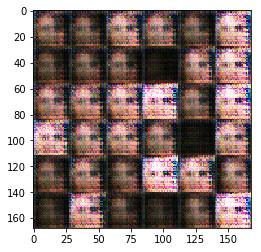

Step 110 - Epoch 1/1 - Gen Loss: 1.3825684785842896 - Disc Loss: 0.4516238570213318
Step 120 - Epoch 1/1 - Gen Loss: 3.511763095855713 - Disc Loss: 0.6925353407859802
Step 130 - Epoch 1/1 - Gen Loss: 0.7681613564491272 - Disc Loss: 1.3261067867279053
Step 140 - Epoch 1/1 - Gen Loss: 2.2461705207824707 - Disc Loss: 0.3577728569507599
Step 150 - Epoch 1/1 - Gen Loss: 1.5249757766723633 - Disc Loss: 0.4726310968399048
Step 160 - Epoch 1/1 - Gen Loss: 0.328570693731308 - Disc Loss: 1.4669189453125
Step 170 - Epoch 1/1 - Gen Loss: 1.559114933013916 - Disc Loss: 0.5679079294204712
Step 180 - Epoch 1/1 - Gen Loss: 6.939467430114746 - Disc Loss: 1.9273136854171753
Step 190 - Epoch 1/1 - Gen Loss: 2.000108242034912 - Disc Loss: 0.31263267993927
Step 200 - Epoch 1/1 - Gen Loss: 2.087820529937744 - Disc Loss: 0.29638296365737915


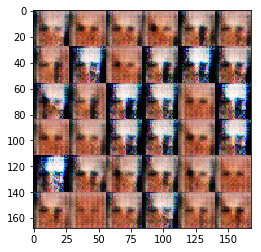

Step 210 - Epoch 1/1 - Gen Loss: 2.968078136444092 - Disc Loss: 0.1752716451883316
Step 220 - Epoch 1/1 - Gen Loss: 6.014559268951416 - Disc Loss: 0.44259247183799744
Step 230 - Epoch 1/1 - Gen Loss: 3.945439100265503 - Disc Loss: 0.11946222931146622
Step 240 - Epoch 1/1 - Gen Loss: 0.4257217049598694 - Disc Loss: 1.888728141784668
Step 250 - Epoch 1/1 - Gen Loss: 3.141528606414795 - Disc Loss: 0.8760043978691101
Step 260 - Epoch 1/1 - Gen Loss: 1.8848795890808105 - Disc Loss: 0.6427848935127258
Step 270 - Epoch 1/1 - Gen Loss: 2.8013834953308105 - Disc Loss: 0.1759970784187317
Step 280 - Epoch 1/1 - Gen Loss: 1.4262444972991943 - Disc Loss: 0.501174807548523
Step 290 - Epoch 1/1 - Gen Loss: 0.5969457626342773 - Disc Loss: 0.9395565986633301
Step 300 - Epoch 1/1 - Gen Loss: 1.9954886436462402 - Disc Loss: 0.6752421855926514


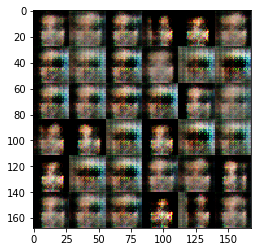

Step 310 - Epoch 1/1 - Gen Loss: 1.5683631896972656 - Disc Loss: 0.5969927906990051
Step 320 - Epoch 1/1 - Gen Loss: 2.519333839416504 - Disc Loss: 0.5664781332015991
Step 330 - Epoch 1/1 - Gen Loss: 1.7740228176116943 - Disc Loss: 0.6514008045196533
Step 340 - Epoch 1/1 - Gen Loss: 2.0710690021514893 - Disc Loss: 0.5069153308868408
Step 350 - Epoch 1/1 - Gen Loss: 0.8879004716873169 - Disc Loss: 1.03819739818573
Step 360 - Epoch 1/1 - Gen Loss: 1.4248180389404297 - Disc Loss: 0.7192876935005188
Step 370 - Epoch 1/1 - Gen Loss: 3.159064769744873 - Disc Loss: 1.1439285278320312
Step 380 - Epoch 1/1 - Gen Loss: 2.3075060844421387 - Disc Loss: 1.006091833114624
Step 390 - Epoch 1/1 - Gen Loss: 1.8270546197891235 - Disc Loss: 0.3563084006309509
Step 400 - Epoch 1/1 - Gen Loss: 0.5469648838043213 - Disc Loss: 1.2226815223693848


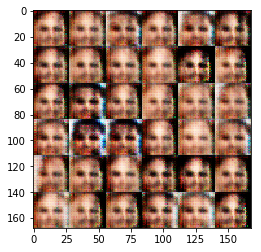

Step 410 - Epoch 1/1 - Gen Loss: 0.848560631275177 - Disc Loss: 1.2956033945083618
Step 420 - Epoch 1/1 - Gen Loss: 0.6170493960380554 - Disc Loss: 1.0632493495941162
Step 430 - Epoch 1/1 - Gen Loss: 1.2980093955993652 - Disc Loss: 0.6218665838241577
Step 440 - Epoch 1/1 - Gen Loss: 1.989499568939209 - Disc Loss: 0.46957239508628845
Step 450 - Epoch 1/1 - Gen Loss: 1.5529381036758423 - Disc Loss: 0.8925420045852661
Step 460 - Epoch 1/1 - Gen Loss: 1.811842918395996 - Disc Loss: 0.6002296209335327
Step 470 - Epoch 1/1 - Gen Loss: 1.6754629611968994 - Disc Loss: 0.7330337762832642
Step 480 - Epoch 1/1 - Gen Loss: 2.3256478309631348 - Disc Loss: 0.99680495262146
Step 490 - Epoch 1/1 - Gen Loss: 2.335261821746826 - Disc Loss: 0.7309830784797668
Step 500 - Epoch 1/1 - Gen Loss: 0.8866302967071533 - Disc Loss: 0.7316350340843201


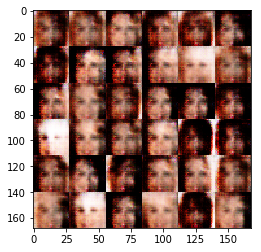

Step 510 - Epoch 1/1 - Gen Loss: 1.2682604789733887 - Disc Loss: 0.7600089311599731
Step 520 - Epoch 1/1 - Gen Loss: 0.7961133718490601 - Disc Loss: 1.161163091659546
Step 530 - Epoch 1/1 - Gen Loss: 1.978332281112671 - Disc Loss: 0.6284699440002441
Step 540 - Epoch 1/1 - Gen Loss: 2.3989570140838623 - Disc Loss: 0.5667094588279724
Step 550 - Epoch 1/1 - Gen Loss: 0.4970114827156067 - Disc Loss: 1.1686381101608276
Step 560 - Epoch 1/1 - Gen Loss: 1.9723650217056274 - Disc Loss: 0.3822544813156128
Step 570 - Epoch 1/1 - Gen Loss: 3.2416491508483887 - Disc Loss: 1.0048125982284546
Step 580 - Epoch 1/1 - Gen Loss: 1.8105883598327637 - Disc Loss: 0.7586937546730042
Step 590 - Epoch 1/1 - Gen Loss: 1.9436390399932861 - Disc Loss: 0.9182721376419067
Step 600 - Epoch 1/1 - Gen Loss: 2.497699737548828 - Disc Loss: 0.729891836643219


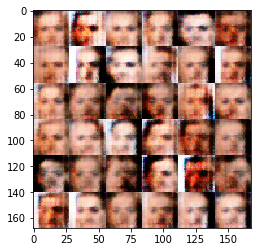

Step 610 - Epoch 1/1 - Gen Loss: 2.303135395050049 - Disc Loss: 0.8086942434310913
Step 620 - Epoch 1/1 - Gen Loss: 2.3590946197509766 - Disc Loss: 0.70915687084198
Step 630 - Epoch 1/1 - Gen Loss: 1.081445574760437 - Disc Loss: 0.7574465274810791
Step 640 - Epoch 1/1 - Gen Loss: 0.4891849756240845 - Disc Loss: 1.407772421836853
Step 650 - Epoch 1/1 - Gen Loss: 2.4007344245910645 - Disc Loss: 0.48526644706726074
Step 660 - Epoch 1/1 - Gen Loss: 1.050102949142456 - Disc Loss: 0.8949053287506104
Step 670 - Epoch 1/1 - Gen Loss: 0.697685718536377 - Disc Loss: 0.9972373247146606
Step 680 - Epoch 1/1 - Gen Loss: 1.8656995296478271 - Disc Loss: 0.6445891857147217
Step 690 - Epoch 1/1 - Gen Loss: 2.3406107425689697 - Disc Loss: 0.5830755829811096
Step 700 - Epoch 1/1 - Gen Loss: 3.044806480407715 - Disc Loss: 0.2409069538116455


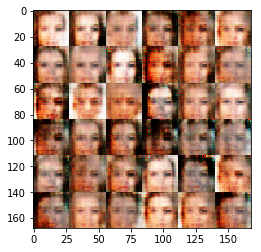

Step 710 - Epoch 1/1 - Gen Loss: 0.8619656562805176 - Disc Loss: 0.8378030061721802
Step 720 - Epoch 1/1 - Gen Loss: 1.5290228128433228 - Disc Loss: 0.7090649604797363
Step 730 - Epoch 1/1 - Gen Loss: 2.165365695953369 - Disc Loss: 0.6759382486343384
Step 740 - Epoch 1/1 - Gen Loss: 0.7432175278663635 - Disc Loss: 0.972732424736023
Step 750 - Epoch 1/1 - Gen Loss: 2.363023042678833 - Disc Loss: 0.9940767288208008
Step 760 - Epoch 1/1 - Gen Loss: 2.064598321914673 - Disc Loss: 1.1244090795516968
Step 770 - Epoch 1/1 - Gen Loss: 1.8374319076538086 - Disc Loss: 0.5234278440475464
Step 780 - Epoch 1/1 - Gen Loss: 1.492487907409668 - Disc Loss: 0.5290572643280029
Step 790 - Epoch 1/1 - Gen Loss: 1.8274424076080322 - Disc Loss: 0.9388003349304199
Step 800 - Epoch 1/1 - Gen Loss: 1.7800276279449463 - Disc Loss: 0.6458541750907898


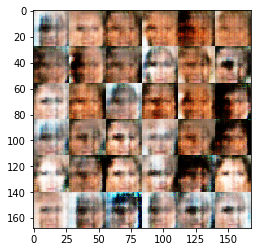

Step 810 - Epoch 1/1 - Gen Loss: 1.3455159664154053 - Disc Loss: 0.6690951585769653
Step 820 - Epoch 1/1 - Gen Loss: 1.5835710763931274 - Disc Loss: 0.8304717540740967
Step 830 - Epoch 1/1 - Gen Loss: 1.089699387550354 - Disc Loss: 0.692423939704895
Step 840 - Epoch 1/1 - Gen Loss: 1.619343638420105 - Disc Loss: 0.5804101228713989
Step 850 - Epoch 1/1 - Gen Loss: 1.0270737409591675 - Disc Loss: 0.8044760227203369
Step 860 - Epoch 1/1 - Gen Loss: 0.8026825189590454 - Disc Loss: 0.9044519066810608
Step 870 - Epoch 1/1 - Gen Loss: 0.40876615047454834 - Disc Loss: 1.4418827295303345
Step 880 - Epoch 1/1 - Gen Loss: 0.42242658138275146 - Disc Loss: 1.527264952659607
Step 890 - Epoch 1/1 - Gen Loss: 1.0087549686431885 - Disc Loss: 1.0512886047363281
Step 900 - Epoch 1/1 - Gen Loss: 0.966758668422699 - Disc Loss: 0.7842401266098022


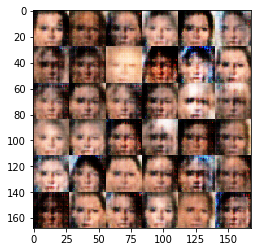

Step 910 - Epoch 1/1 - Gen Loss: 1.0820378065109253 - Disc Loss: 0.9657583236694336
Step 920 - Epoch 1/1 - Gen Loss: 1.8943419456481934 - Disc Loss: 0.774196445941925
Step 930 - Epoch 1/1 - Gen Loss: 2.4560506343841553 - Disc Loss: 0.29675835371017456
Step 940 - Epoch 1/1 - Gen Loss: 1.6075206995010376 - Disc Loss: 0.6025368571281433
Step 950 - Epoch 1/1 - Gen Loss: 0.30635911226272583 - Disc Loss: 1.8407777547836304
Step 960 - Epoch 1/1 - Gen Loss: 1.1408746242523193 - Disc Loss: 0.5790090560913086
Step 970 - Epoch 1/1 - Gen Loss: 1.7882201671600342 - Disc Loss: 0.5633834600448608
Step 980 - Epoch 1/1 - Gen Loss: 3.089329957962036 - Disc Loss: 1.2800335884094238
Step 990 - Epoch 1/1 - Gen Loss: 0.7680394649505615 - Disc Loss: 1.05879807472229
Step 1000 - Epoch 1/1 - Gen Loss: 2.622427463531494 - Disc Loss: 0.848176121711731


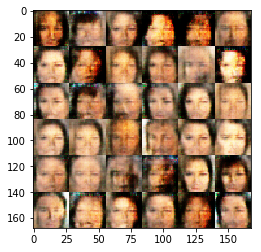

Step 1010 - Epoch 1/1 - Gen Loss: 2.2418370246887207 - Disc Loss: 0.5781552791595459
Step 1020 - Epoch 1/1 - Gen Loss: 1.871107816696167 - Disc Loss: 0.8725869059562683
Step 1030 - Epoch 1/1 - Gen Loss: 1.5398391485214233 - Disc Loss: 0.7767349481582642
Step 1040 - Epoch 1/1 - Gen Loss: 1.0061476230621338 - Disc Loss: 0.7750113606452942
Step 1050 - Epoch 1/1 - Gen Loss: 1.0775996446609497 - Disc Loss: 0.7243298292160034
Step 1060 - Epoch 1/1 - Gen Loss: 0.5444759130477905 - Disc Loss: 1.3584895133972168
Step 1070 - Epoch 1/1 - Gen Loss: 1.618760585784912 - Disc Loss: 0.9324316382408142
Step 1080 - Epoch 1/1 - Gen Loss: 1.3355371952056885 - Disc Loss: 0.7294633388519287
Step 1090 - Epoch 1/1 - Gen Loss: 1.1944317817687988 - Disc Loss: 1.0683958530426025
Step 1100 - Epoch 1/1 - Gen Loss: 1.2652448415756226 - Disc Loss: 0.6832058429718018


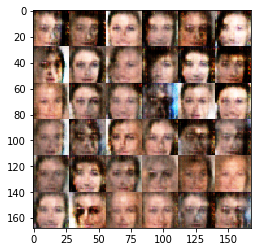

Step 1110 - Epoch 1/1 - Gen Loss: 2.452763080596924 - Disc Loss: 0.9553669691085815
Step 1120 - Epoch 1/1 - Gen Loss: 1.035109281539917 - Disc Loss: 0.7163913249969482
Step 1130 - Epoch 1/1 - Gen Loss: 1.172631025314331 - Disc Loss: 0.7764360904693604
Step 1140 - Epoch 1/1 - Gen Loss: 0.6705729961395264 - Disc Loss: 1.2150105237960815
Step 1150 - Epoch 1/1 - Gen Loss: 0.8800936341285706 - Disc Loss: 0.9477074146270752
Step 1160 - Epoch 1/1 - Gen Loss: 0.944748044013977 - Disc Loss: 1.1222468614578247
Step 1170 - Epoch 1/1 - Gen Loss: 0.811795175075531 - Disc Loss: 0.9111771583557129
Step 1180 - Epoch 1/1 - Gen Loss: 1.2942687273025513 - Disc Loss: 0.7908216714859009
Step 1190 - Epoch 1/1 - Gen Loss: 2.223666191101074 - Disc Loss: 0.7772513031959534
Step 1200 - Epoch 1/1 - Gen Loss: 0.6833268404006958 - Disc Loss: 1.1332911252975464


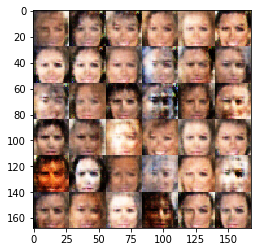

Step 1210 - Epoch 1/1 - Gen Loss: 1.228196382522583 - Disc Loss: 0.598726749420166
Step 1220 - Epoch 1/1 - Gen Loss: 1.0593540668487549 - Disc Loss: 0.8137041330337524
Step 1230 - Epoch 1/1 - Gen Loss: 1.430847406387329 - Disc Loss: 0.7508606314659119
Step 1240 - Epoch 1/1 - Gen Loss: 1.1183626651763916 - Disc Loss: 0.9132139682769775
Step 1250 - Epoch 1/1 - Gen Loss: 2.0999703407287598 - Disc Loss: 0.7625544667243958
Step 1260 - Epoch 1/1 - Gen Loss: 1.617131233215332 - Disc Loss: 0.8043262958526611
Step 1270 - Epoch 1/1 - Gen Loss: 0.9055584073066711 - Disc Loss: 0.8985690474510193
Step 1280 - Epoch 1/1 - Gen Loss: 1.8202314376831055 - Disc Loss: 0.480729877948761
Step 1290 - Epoch 1/1 - Gen Loss: 1.3655316829681396 - Disc Loss: 0.7691749334335327
Step 1300 - Epoch 1/1 - Gen Loss: 1.978860855102539 - Disc Loss: 1.017666220664978


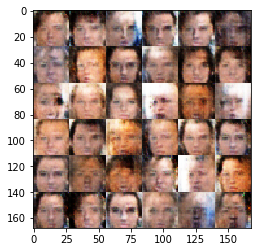

Step 1310 - Epoch 1/1 - Gen Loss: 1.4818755388259888 - Disc Loss: 0.7039512991905212
Step 1320 - Epoch 1/1 - Gen Loss: 2.1016998291015625 - Disc Loss: 1.2680178880691528
Step 1330 - Epoch 1/1 - Gen Loss: 1.837616205215454 - Disc Loss: 0.65595543384552
Step 1340 - Epoch 1/1 - Gen Loss: 1.2389237880706787 - Disc Loss: 0.7953730821609497
Step 1350 - Epoch 1/1 - Gen Loss: 1.3969488143920898 - Disc Loss: 0.7030041217803955
Step 1360 - Epoch 1/1 - Gen Loss: 1.4067456722259521 - Disc Loss: 0.7034499645233154
Step 1370 - Epoch 1/1 - Gen Loss: 2.0883097648620605 - Disc Loss: 0.8000310659408569
Step 1380 - Epoch 1/1 - Gen Loss: 1.6789313554763794 - Disc Loss: 0.6931318640708923
Step 1390 - Epoch 1/1 - Gen Loss: 0.3038807213306427 - Disc Loss: 1.7804745435714722
Step 1400 - Epoch 1/1 - Gen Loss: 2.4202232360839844 - Disc Loss: 0.8917805552482605


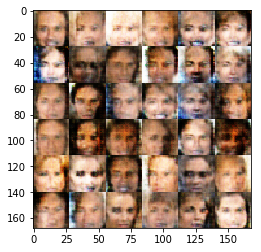

Step 1410 - Epoch 1/1 - Gen Loss: 0.5691953897476196 - Disc Loss: 1.2685546875
Step 1420 - Epoch 1/1 - Gen Loss: 1.5142592191696167 - Disc Loss: 0.49881041049957275
Step 1430 - Epoch 1/1 - Gen Loss: 1.8754079341888428 - Disc Loss: 0.6861191391944885
Step 1440 - Epoch 1/1 - Gen Loss: 2.272230625152588 - Disc Loss: 0.8350027203559875
Step 1450 - Epoch 1/1 - Gen Loss: 2.76741623878479 - Disc Loss: 0.918285071849823
Step 1460 - Epoch 1/1 - Gen Loss: 1.586387038230896 - Disc Loss: 0.8518026471138
Step 1470 - Epoch 1/1 - Gen Loss: 0.6249914765357971 - Disc Loss: 1.3688358068466187
Step 1480 - Epoch 1/1 - Gen Loss: 0.9927025437355042 - Disc Loss: 0.97585529088974
Step 1490 - Epoch 1/1 - Gen Loss: 1.6292767524719238 - Disc Loss: 0.7060182094573975
Step 1500 - Epoch 1/1 - Gen Loss: 1.5128167867660522 - Disc Loss: 0.6436518430709839


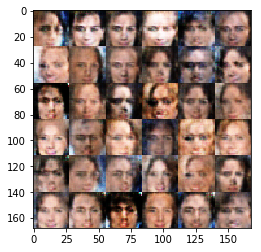

Step 1510 - Epoch 1/1 - Gen Loss: 1.8737292289733887 - Disc Loss: 0.8490278720855713
Step 1520 - Epoch 1/1 - Gen Loss: 0.9243389964103699 - Disc Loss: 1.0156551599502563
Step 1530 - Epoch 1/1 - Gen Loss: 1.8007761240005493 - Disc Loss: 0.7690701484680176
Step 1540 - Epoch 1/1 - Gen Loss: 0.31312698125839233 - Disc Loss: 1.6723062992095947
Step 1550 - Epoch 1/1 - Gen Loss: 1.1135330200195312 - Disc Loss: 0.8346719741821289
Step 1560 - Epoch 1/1 - Gen Loss: 2.1961967945098877 - Disc Loss: 0.7135604619979858
Step 1570 - Epoch 1/1 - Gen Loss: 1.8915860652923584 - Disc Loss: 0.8832204937934875
Step 1580 - Epoch 1/1 - Gen Loss: 0.695263147354126 - Disc Loss: 1.180898904800415
Step 1590 - Epoch 1/1 - Gen Loss: 0.779340386390686 - Disc Loss: 1.047968864440918
Step 1600 - Epoch 1/1 - Gen Loss: 0.9932591319084167 - Disc Loss: 0.8876113891601562


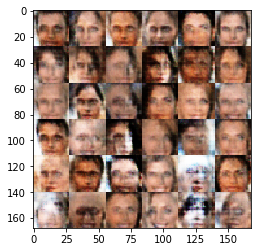

Step 1610 - Epoch 1/1 - Gen Loss: 2.825242757797241 - Disc Loss: 0.9647312164306641
Step 1620 - Epoch 1/1 - Gen Loss: 1.3965692520141602 - Disc Loss: 0.9579451680183411
Step 1630 - Epoch 1/1 - Gen Loss: 2.051025152206421 - Disc Loss: 0.6398540139198303
Step 1640 - Epoch 1/1 - Gen Loss: 1.3670780658721924 - Disc Loss: 0.7076960802078247
Step 1650 - Epoch 1/1 - Gen Loss: 0.7648254036903381 - Disc Loss: 1.0551353693008423
Step 1660 - Epoch 1/1 - Gen Loss: 1.402017593383789 - Disc Loss: 0.8886175155639648
Step 1670 - Epoch 1/1 - Gen Loss: 0.36027103662490845 - Disc Loss: 1.4546688795089722
Step 1680 - Epoch 1/1 - Gen Loss: 0.9309860467910767 - Disc Loss: 0.8685897588729858
Step 1690 - Epoch 1/1 - Gen Loss: 1.293769359588623 - Disc Loss: 0.8333637118339539
Step 1700 - Epoch 1/1 - Gen Loss: 0.6995267868041992 - Disc Loss: 0.9765970706939697


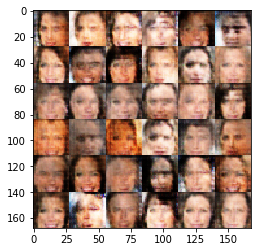

Step 1710 - Epoch 1/1 - Gen Loss: 1.2679507732391357 - Disc Loss: 0.666174054145813
Step 1720 - Epoch 1/1 - Gen Loss: 0.825779914855957 - Disc Loss: 0.9809386730194092
Step 1730 - Epoch 1/1 - Gen Loss: 1.3220136165618896 - Disc Loss: 0.6848582625389099
Step 1740 - Epoch 1/1 - Gen Loss: 1.3048632144927979 - Disc Loss: 0.7808762788772583
Step 1750 - Epoch 1/1 - Gen Loss: 2.1707065105438232 - Disc Loss: 0.7799029350280762
Step 1760 - Epoch 1/1 - Gen Loss: 0.8181536793708801 - Disc Loss: 0.944941520690918
Step 1770 - Epoch 1/1 - Gen Loss: 0.8121617436408997 - Disc Loss: 0.8270434141159058
Step 1780 - Epoch 1/1 - Gen Loss: 1.2261407375335693 - Disc Loss: 0.8479557633399963
Step 1790 - Epoch 1/1 - Gen Loss: 2.0448598861694336 - Disc Loss: 0.7341017127037048
Step 1800 - Epoch 1/1 - Gen Loss: 2.837258815765381 - Disc Loss: 0.6807528734207153


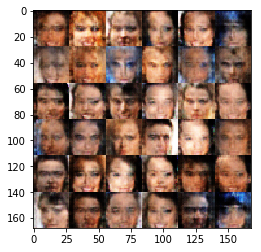

Step 1810 - Epoch 1/1 - Gen Loss: 1.7262263298034668 - Disc Loss: 0.9330016374588013
Step 1820 - Epoch 1/1 - Gen Loss: 1.6799767017364502 - Disc Loss: 0.7647342681884766
Step 1830 - Epoch 1/1 - Gen Loss: 1.8363280296325684 - Disc Loss: 1.1848596334457397
Step 1840 - Epoch 1/1 - Gen Loss: 1.014521598815918 - Disc Loss: 0.9023697972297668
Step 1850 - Epoch 1/1 - Gen Loss: 1.9700837135314941 - Disc Loss: 0.6113759875297546
Step 1860 - Epoch 1/1 - Gen Loss: 1.6851624250411987 - Disc Loss: 0.8217017650604248
Step 1870 - Epoch 1/1 - Gen Loss: 0.8064782619476318 - Disc Loss: 0.998505711555481
Step 1880 - Epoch 1/1 - Gen Loss: 1.6574952602386475 - Disc Loss: 0.7140724658966064
Step 1890 - Epoch 1/1 - Gen Loss: 0.9140281081199646 - Disc Loss: 0.8905767798423767
Step 1900 - Epoch 1/1 - Gen Loss: 1.8541191816329956 - Disc Loss: 0.9330031871795654


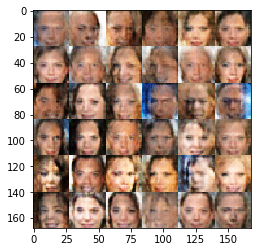

Step 1910 - Epoch 1/1 - Gen Loss: 1.047751784324646 - Disc Loss: 0.8230466842651367
Step 1920 - Epoch 1/1 - Gen Loss: 0.8592920899391174 - Disc Loss: 1.0044686794281006
Step 1930 - Epoch 1/1 - Gen Loss: 1.5641686916351318 - Disc Loss: 0.7440214157104492
Step 1940 - Epoch 1/1 - Gen Loss: 1.5347034931182861 - Disc Loss: 0.994390070438385
Step 1950 - Epoch 1/1 - Gen Loss: 1.267327070236206 - Disc Loss: 0.8380210399627686
Step 1960 - Epoch 1/1 - Gen Loss: 1.077221393585205 - Disc Loss: 0.801642119884491
Step 1970 - Epoch 1/1 - Gen Loss: 1.687417984008789 - Disc Loss: 0.6495823264122009
Step 1980 - Epoch 1/1 - Gen Loss: 0.9602734446525574 - Disc Loss: 0.9485321640968323
Step 1990 - Epoch 1/1 - Gen Loss: 0.9803258180618286 - Disc Loss: 0.8710253238677979
Step 2000 - Epoch 1/1 - Gen Loss: 1.0229952335357666 - Disc Loss: 0.8622896671295166


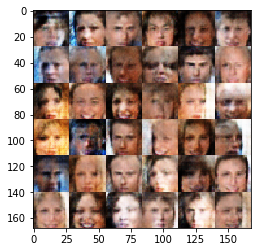

Step 2010 - Epoch 1/1 - Gen Loss: 1.7253109216690063 - Disc Loss: 0.8094708919525146
Step 2020 - Epoch 1/1 - Gen Loss: 1.338686466217041 - Disc Loss: 0.7718249559402466
Step 2030 - Epoch 1/1 - Gen Loss: 1.8064401149749756 - Disc Loss: 0.8404536247253418
Step 2040 - Epoch 1/1 - Gen Loss: 1.2357810735702515 - Disc Loss: 0.7131043672561646
Step 2050 - Epoch 1/1 - Gen Loss: 2.089122772216797 - Disc Loss: 0.6916415691375732
Step 2060 - Epoch 1/1 - Gen Loss: 0.5682662129402161 - Disc Loss: 1.1247349977493286
Step 2070 - Epoch 1/1 - Gen Loss: 0.9150539636611938 - Disc Loss: 1.061039924621582
Step 2080 - Epoch 1/1 - Gen Loss: 1.0562143325805664 - Disc Loss: 0.8720607757568359
Step 2090 - Epoch 1/1 - Gen Loss: 0.8408328294754028 - Disc Loss: 1.1145594120025635
Step 2100 - Epoch 1/1 - Gen Loss: 1.0057344436645508 - Disc Loss: 0.8894518613815308


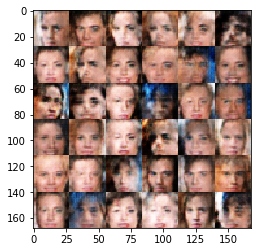

Step 2110 - Epoch 1/1 - Gen Loss: 1.1283936500549316 - Disc Loss: 0.7360210418701172
Step 2120 - Epoch 1/1 - Gen Loss: 0.9226517677307129 - Disc Loss: 0.8512303829193115
Step 2130 - Epoch 1/1 - Gen Loss: 1.4929893016815186 - Disc Loss: 0.632189154624939
Step 2140 - Epoch 1/1 - Gen Loss: 1.0595686435699463 - Disc Loss: 0.8661717176437378
Step 2150 - Epoch 1/1 - Gen Loss: 1.3593454360961914 - Disc Loss: 0.6852236986160278
Step 2160 - Epoch 1/1 - Gen Loss: 0.7639225721359253 - Disc Loss: 0.9614913463592529
Step 2170 - Epoch 1/1 - Gen Loss: 0.9199262857437134 - Disc Loss: 0.8672412633895874
Step 2180 - Epoch 1/1 - Gen Loss: 1.288022518157959 - Disc Loss: 0.9299870133399963
Step 2190 - Epoch 1/1 - Gen Loss: 1.2399799823760986 - Disc Loss: 0.785513162612915
Step 2200 - Epoch 1/1 - Gen Loss: 2.153394937515259 - Disc Loss: 0.9466779232025146


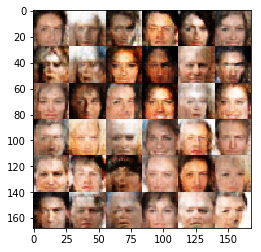

Step 2210 - Epoch 1/1 - Gen Loss: 1.3807573318481445 - Disc Loss: 0.7314652800559998
Step 2220 - Epoch 1/1 - Gen Loss: 1.1834040880203247 - Disc Loss: 0.9235034584999084
Step 2230 - Epoch 1/1 - Gen Loss: 2.0567243099212646 - Disc Loss: 1.0300769805908203
Step 2240 - Epoch 1/1 - Gen Loss: 1.4235775470733643 - Disc Loss: 0.5308117270469666
Step 2250 - Epoch 1/1 - Gen Loss: 0.3059360086917877 - Disc Loss: 1.682058334350586
Step 2260 - Epoch 1/1 - Gen Loss: 1.0107033252716064 - Disc Loss: 0.8555327653884888
Step 2270 - Epoch 1/1 - Gen Loss: 2.6192758083343506 - Disc Loss: 0.766534686088562
Step 2280 - Epoch 1/1 - Gen Loss: 0.8825037479400635 - Disc Loss: 0.8852494359016418
Step 2290 - Epoch 1/1 - Gen Loss: 1.3915011882781982 - Disc Loss: 0.7296963930130005
Step 2300 - Epoch 1/1 - Gen Loss: 1.7865687608718872 - Disc Loss: 0.8485060334205627


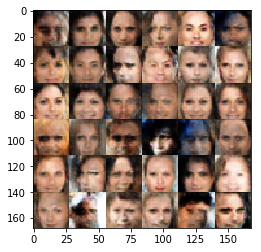

Step 2310 - Epoch 1/1 - Gen Loss: 1.6455450057983398 - Disc Loss: 0.7865434885025024
Step 2320 - Epoch 1/1 - Gen Loss: 1.5245846509933472 - Disc Loss: 0.8248962759971619
Step 2330 - Epoch 1/1 - Gen Loss: 1.3043973445892334 - Disc Loss: 0.7479650378227234
Step 2340 - Epoch 1/1 - Gen Loss: 0.9996349811553955 - Disc Loss: 0.809791088104248
Step 2350 - Epoch 1/1 - Gen Loss: 1.3808214664459229 - Disc Loss: 0.9372888207435608
Step 2360 - Epoch 1/1 - Gen Loss: 0.9758062362670898 - Disc Loss: 0.7312994003295898
Step 2370 - Epoch 1/1 - Gen Loss: 1.7002782821655273 - Disc Loss: 0.8823697566986084
Step 2380 - Epoch 1/1 - Gen Loss: 1.6687654256820679 - Disc Loss: 0.7417596578598022
Step 2390 - Epoch 1/1 - Gen Loss: 1.0257327556610107 - Disc Loss: 0.8208200931549072
Step 2400 - Epoch 1/1 - Gen Loss: 2.3130786418914795 - Disc Loss: 1.1015316247940063


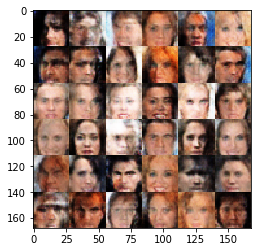

Step 2410 - Epoch 1/1 - Gen Loss: 1.1094191074371338 - Disc Loss: 0.8722615242004395
Step 2420 - Epoch 1/1 - Gen Loss: 1.244442343711853 - Disc Loss: 0.6977588534355164
Step 2430 - Epoch 1/1 - Gen Loss: 1.2632486820220947 - Disc Loss: 0.7043360471725464
Step 2440 - Epoch 1/1 - Gen Loss: 0.7119379043579102 - Disc Loss: 1.0738580226898193
Step 2450 - Epoch 1/1 - Gen Loss: 0.9484692215919495 - Disc Loss: 0.889156699180603
Step 2460 - Epoch 1/1 - Gen Loss: 0.6774373054504395 - Disc Loss: 1.0840328931808472
Step 2470 - Epoch 1/1 - Gen Loss: 1.591602087020874 - Disc Loss: 0.6891955137252808
Step 2480 - Epoch 1/1 - Gen Loss: 0.9076595306396484 - Disc Loss: 1.0688302516937256
Step 2490 - Epoch 1/1 - Gen Loss: 1.069505214691162 - Disc Loss: 1.0571974515914917
Step 2500 - Epoch 1/1 - Gen Loss: 1.8431830406188965 - Disc Loss: 0.9101989269256592


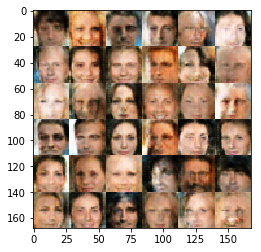

Step 2510 - Epoch 1/1 - Gen Loss: 1.8013331890106201 - Disc Loss: 1.0625300407409668
Step 2520 - Epoch 1/1 - Gen Loss: 2.099249839782715 - Disc Loss: 0.7899110913276672
Step 2530 - Epoch 1/1 - Gen Loss: 0.5062028169631958 - Disc Loss: 1.2602132558822632
Step 2540 - Epoch 1/1 - Gen Loss: 0.7792179584503174 - Disc Loss: 1.029202938079834
Step 2550 - Epoch 1/1 - Gen Loss: 0.9425067901611328 - Disc Loss: 0.9095674753189087
Step 2560 - Epoch 1/1 - Gen Loss: 1.443748116493225 - Disc Loss: 0.9726698994636536
Step 2570 - Epoch 1/1 - Gen Loss: 1.3863742351531982 - Disc Loss: 0.7093400955200195
Step 2580 - Epoch 1/1 - Gen Loss: 1.6396896839141846 - Disc Loss: 0.8164272308349609
Step 2590 - Epoch 1/1 - Gen Loss: 1.3176360130310059 - Disc Loss: 0.7605470418930054
Step 2600 - Epoch 1/1 - Gen Loss: 0.4593966007232666 - Disc Loss: 1.3758084774017334


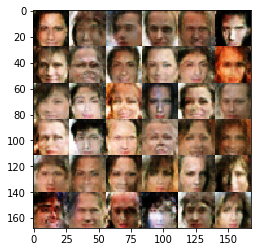

Step 2610 - Epoch 1/1 - Gen Loss: 0.6462120413780212 - Disc Loss: 1.1819711923599243
Step 2620 - Epoch 1/1 - Gen Loss: 2.195462703704834 - Disc Loss: 0.7655196189880371
Step 2630 - Epoch 1/1 - Gen Loss: 1.498744010925293 - Disc Loss: 0.7192542552947998
Step 2640 - Epoch 1/1 - Gen Loss: 2.6771905422210693 - Disc Loss: 1.1099129915237427
Step 2650 - Epoch 1/1 - Gen Loss: 1.0646291971206665 - Disc Loss: 0.9397870898246765


KeyboardInterrupt: 

In [31]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.